In [24]:
import os
import sys
sys.path.append('cocoapi\PythonAPI')
from pycocotools.coco import COCO

In [25]:
dataDir = 'cocoapi/'
dataType = 'val2017'
instances_annFile = os.path.join(dataDir, 'annotations/instances_{}.json'.format(dataType))
coco = COCO(instances_annFile)

loading annotations into memory... cocoapi/annotations/instances_val2017.json
Done (t=1.32s)
creating index...
index created!


In [26]:
# initialize COCO API for caption annotations
captions_annFile = os.path.join(dataDir, 'annotations/captions_{}.json'.format(dataType))
coco_caps = COCO(captions_annFile)

# get image ids 
ids = list(coco.anns.keys())

loading annotations into memory... cocoapi/annotations/captions_val2017.json
Done (t=0.35s)
creating index...
index created!


In [27]:
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
%matplotlib inline

# pick a random image and obtain the corresponding URL
ann_id = np.random.choice(ids)
img_id = coco.anns[ann_id]['image_id']
img = coco.loadImgs(img_id)[0]
url = img['coco_url']

http://images.cocodataset.org/val2017/000000394328.jpg


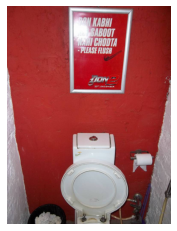

There is an indoor toilet underneath a sign that says please flush. 
A sign is seen posted above a toilet.
A bathroom with a red wall and poster in front of a toilet.
This bathroom has red and white walls and a poster.
A toilet with a poster above it in a bathroom


In [28]:
# print URL and visualize corresponding image
print(url)
I = io.imread(url)
plt.axis('off')
plt.imshow(I)
plt.show()

# load and display captions
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)

In [29]:
import sys
sys.path.append('cocoapi\PythonAPI')
from pycocotools.coco import COCO
import nltk
nltk.download('punkt')
from data_loader import get_loader
from torchvision import transforms


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
import sys
sys.path.append('cocoapi\PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from model import EncoderCNN, DecoderRNN
import math


## TODO #1: Select appropriate values for the Python variables below.
batch_size = 256           # batch size
vocab_threshold = 4        # minimum word count threshold
vocab_from_file = False     # if True, load existing vocab file
embed_size = 512           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_epochs = 3             # number of training epochs
save_every = 1             # determines frequency of saving model weights
print_every = 100          # determines window for printing average loss
log_file = 'training_log.txt'       # name of file with saved training loss and perplexity

# (Optional) TODO #2: Amend the image transform below.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Build data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file)

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder. 
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# TODO #3: Specify the learnable parameters of the model.
params = list(decoder.parameters()) + list(encoder.embed.parameters()) 

# TODO #4: Define the optimizer.
optimizer = torch.optim.Adam(params=params, lr = 0.001)

# Set the total number of training steps per epoch.
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)

loading annotations into memory... cocoapi/annotations/captions_train2017.json
Done (t=0.78s)
creating index...
index created!
[0/591753] Tokenizing captions...
[100000/591753] Tokenizing captions...
[200000/591753] Tokenizing captions...
[300000/591753] Tokenizing captions...
[400000/591753] Tokenizing captions...
[500000/591753] Tokenizing captions...
loading annotations into memory... cocoapi/annotations/captions_train2017.json
Done (t=1.10s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 591753/591753 [01:02<00:00, 9532.52it/s] 
C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# install livelossplot to keep track of the loss function evolving over time
%pip install livelossplot --quiet

Note: you may need to restart the kernel to use updated packages.


The filename, directory name, or volume label syntax is incorrect.


In [ ]:
import torch.utils.data as data
import numpy as np
import os

# for visualization only
from livelossplot import PlotLosses

# Open the training log file.
f = open(log_file, 'w')

# old_time = time.time()
# response = requests.request("GET", 
#                             "http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token", 
#                             headers={"Metadata-Flavor":"Google"})
print("Training started - Loss function info will be reported every 100's steps")
liveloss = PlotLosses()
logs = {}
for epoch in range(1, num_epochs+1):
    running_loss = 0.0
    for i_step in range(1, total_step+1):
        
        # if time.time() - old_time > 60:
        #     old_time = time.time()
        #     requests.request("POST", 
        #                      "https://nebula.udacity.com/api/v1/remote/keep-alive", 
        #                      headers={'Authorization': "STAR " + response.text})
        
        # Randomly sample a caption length, and sample indices with that length.
        indices = data_loader.dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler
        
        # Obtain the batch.
        images, captions = next(iter(data_loader))

        # Move batch of images and captions to GPU if CUDA is available.
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        images = images.to(device)
        captions = captions.to(device)
        
        # Zero the gradients.
        decoder.zero_grad()
        encoder.zero_grad()
        
        # Pass the inputs through the CNN-RNN model.
        features = encoder(images)
        outputs = decoder(features, captions)
        
        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        
        # Backward pass.
        loss.backward()
        
        # Update the parameters in the optimizer.
        optimizer.step()
            
        # Get training statistics.
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))
          
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to file.
        f.write(stats + '\n')
        f.flush()
        
        running_loss += loss.item()
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            #print('\r' + stats)
            # report Loss to perform visualiztion
            avg_loss = running_loss/print_every
            logs['Training Loss'] = avg_loss
            running_loss = 0.0
            # update chart
            liveloss.update(logs)
            liveloss.send()
            
    # Save the weights.
    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), os.path.join('./models', 'decoder-%d.pkl' % epoch))
        torch.save(encoder.state_dict(), os.path.join('./models', 'encoder-%d.pkl' % epoch))

# Close the training log file.
f.close()

Training started - Loss function info will be reported every 100's steps


RuntimeError: mat1 and mat2 shapes cannot be multiplied (172032x224 and 512x768)